### 1. Load CATPCHA images and get the transformed (X,y) data

In [1]:
import torch

from helper_functions.data_transformation import get_transformed_data_v2_without_resize, get_transformed_data_for_captcha_evaluation_without_resize

train_folder = "../data/train/combine"
test_folder = "../data/test/combine"
cached_data_path = "../data/prepared_data_cnn_v6.pth"

try:
    # Load the prepared data from cache if it already exists
    X_train, y_train, X_test, y_test, X_test_captcha, y_test_captcha, failed_segmentation_info = torch.load(cached_data_path)
    print("Loaded prepared data from cache.")

except FileNotFoundError:
    # Else prepare the data and save it
    X_train, y_train = get_transformed_data_v2_without_resize(train_folder, is_train=True)
    X_test, y_test = get_transformed_data_v2_without_resize(test_folder, is_train=False)
    X_test_captcha, y_test_captcha, failed_segmentation_info = get_transformed_data_for_captcha_evaluation_without_resize(test_folder)

    torch.save((X_train, y_train, X_test, y_test, X_test_captcha, y_test_captcha, failed_segmentation_info), cached_data_path)
    print("Saved prepared data to cache.")


Loaded prepared data from cache.


### 2. Instantiate CNN model with SPP layer and train it

In [ ]:
from playground.models.spp_cnn import CNN, CNNParams  # Make sure to save the new model in this path
from helper_functions.data_transformation import IMG_HEIGHT, IMG_WIDTH

# Instantiate model with SPP parameters
cnn_params: CNNParams = {
    "num_classes": 36,
    "input_shape": (1, IMG_HEIGHT, IMG_WIDTH),  # (channels, height, width)
    "learning_rate": 1.1*1e-3,
    "num_epochs": 30,
    "batch_size": 64,  # Reduced batch size for better handling of variable-sized inputs
    "spp_levels": [1, 2, 4]  # SPP pyramid levels: 1x1, 2x2, and 4x4 bins
}
cnn = CNN(cnn_params)

# Train model
cached_model_path = "../trained_models/cnn_v4_spp.pth"
try:
    # Load the trained model from cache if it already exists
    cnn.load_trained_model(cached_model_path)
except FileNotFoundError:
    # Else train the model and save it
    cnn.train_model(X_train, y_train)
    cnn.save_trained_model(cached_model_path)

Trained model (took 227m 12s) has the saved epoch losses: 
Epoch 1, Loss: 2.202339831201788
Epoch 2, Loss: 0.9661766316163987
Epoch 3, Loss: 0.7131885769851705
Epoch 4, Loss: 0.5795769477910536
Epoch 5, Loss: 0.49360341566769195
Epoch 6, Loss: 0.42906618361326465
Epoch 7, Loss: 0.3748784681214368
Epoch 8, Loss: 0.3328517303269177
Epoch 9, Loss: 0.29263539637526936
Epoch 10, Loss: 0.259306983982417
Epoch 11, Loss: 0.23449142503015924
Epoch 12, Loss: 0.13569829348877732
Epoch 13, Loss: 0.11239284288251039
Epoch 14, Loss: 0.1034514829101383
Epoch 15, Loss: 0.09525762694603938
Epoch 16, Loss: 0.05941953368189474
Epoch 17, Loss: 0.050484982694361406
Epoch 18, Loss: 0.04793175437185521
Epoch 19, Loss: 0.04334350910872792
Epoch 20, Loss: 0.03000115361745318
Epoch 21, Loss: 0.026238413227542758
Epoch 22, Loss: 0.02421647868251574
Epoch 23, Loss: 0.02240071418581434
Epoch 24, Loss: 0.017179365925895092
Epoch 25, Loss: 0.015092765811458063
Epoch 26, Loss: 0.013543822966954288
Epoch 27, Loss: 0.0

### 3. Evaluation 

Character level performance (skipping SF): {
  "accuracy": 0.803,
  "precision": 0.813,
  "recall": 0.803,
  "f1_score": 0.805
}

Captcha level performance: {
  "segmentation_accuracy": 0.909,
  "captcha_accuracy (skipping SF)": 0.429,
  "captcha_accuracy (including SF)": 0.39,
  "character_accuracy (including SF)": 0.728
}

Confusion matrix for individual characters (skipping SF):


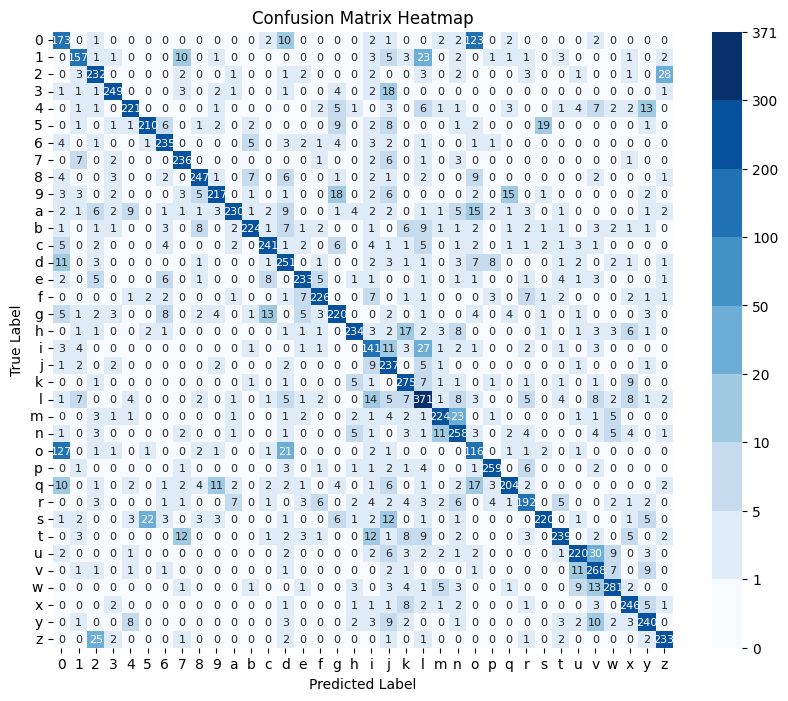

Individual character performance and top confusions (skipping SF):


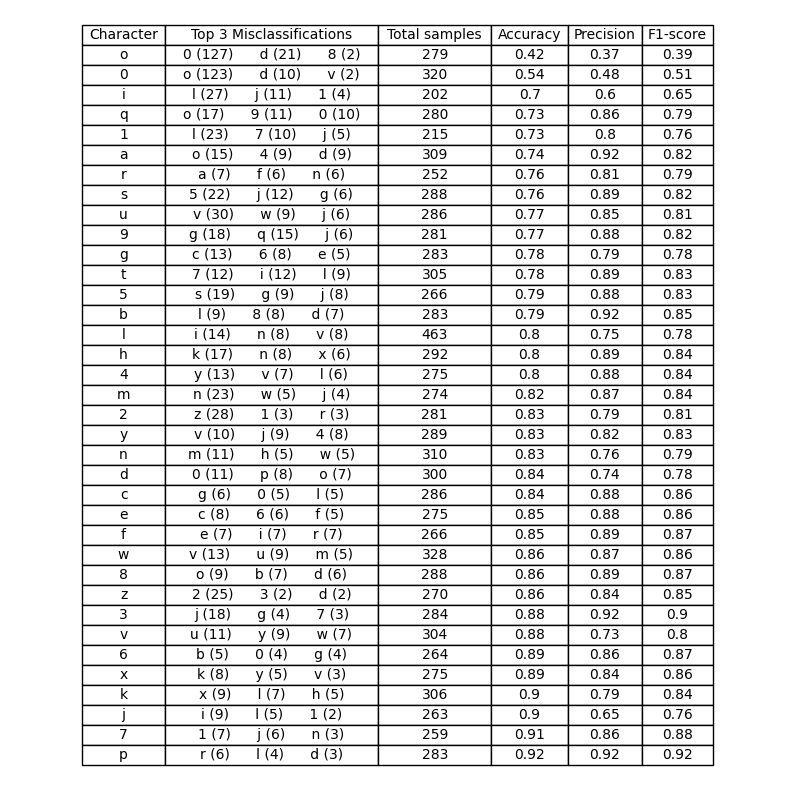

In [ ]:
from playground.helper_functions.evaluation_spp import evaluate_character_performance, evaluate_captcha_performance, evaluate_individual_character_performance

evaluate_character_performance(cnn.model, X_test, y_test)
evaluate_captcha_performance(cnn.model, X_test_captcha, y_test_captcha, failed_segmentation_info)
evaluate_individual_character_performance(cnn.model, X_test, y_test)